In [1]:
!pip install dlt[duckdb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 625.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.9/728.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00


# Introduction to Incremental Loading

Incremental loading is the act of loading only new or changed data and not old records that we already loaded. To understand different methods of data loading, let's look at the following walkthrough.

Imagine a Notion Database:

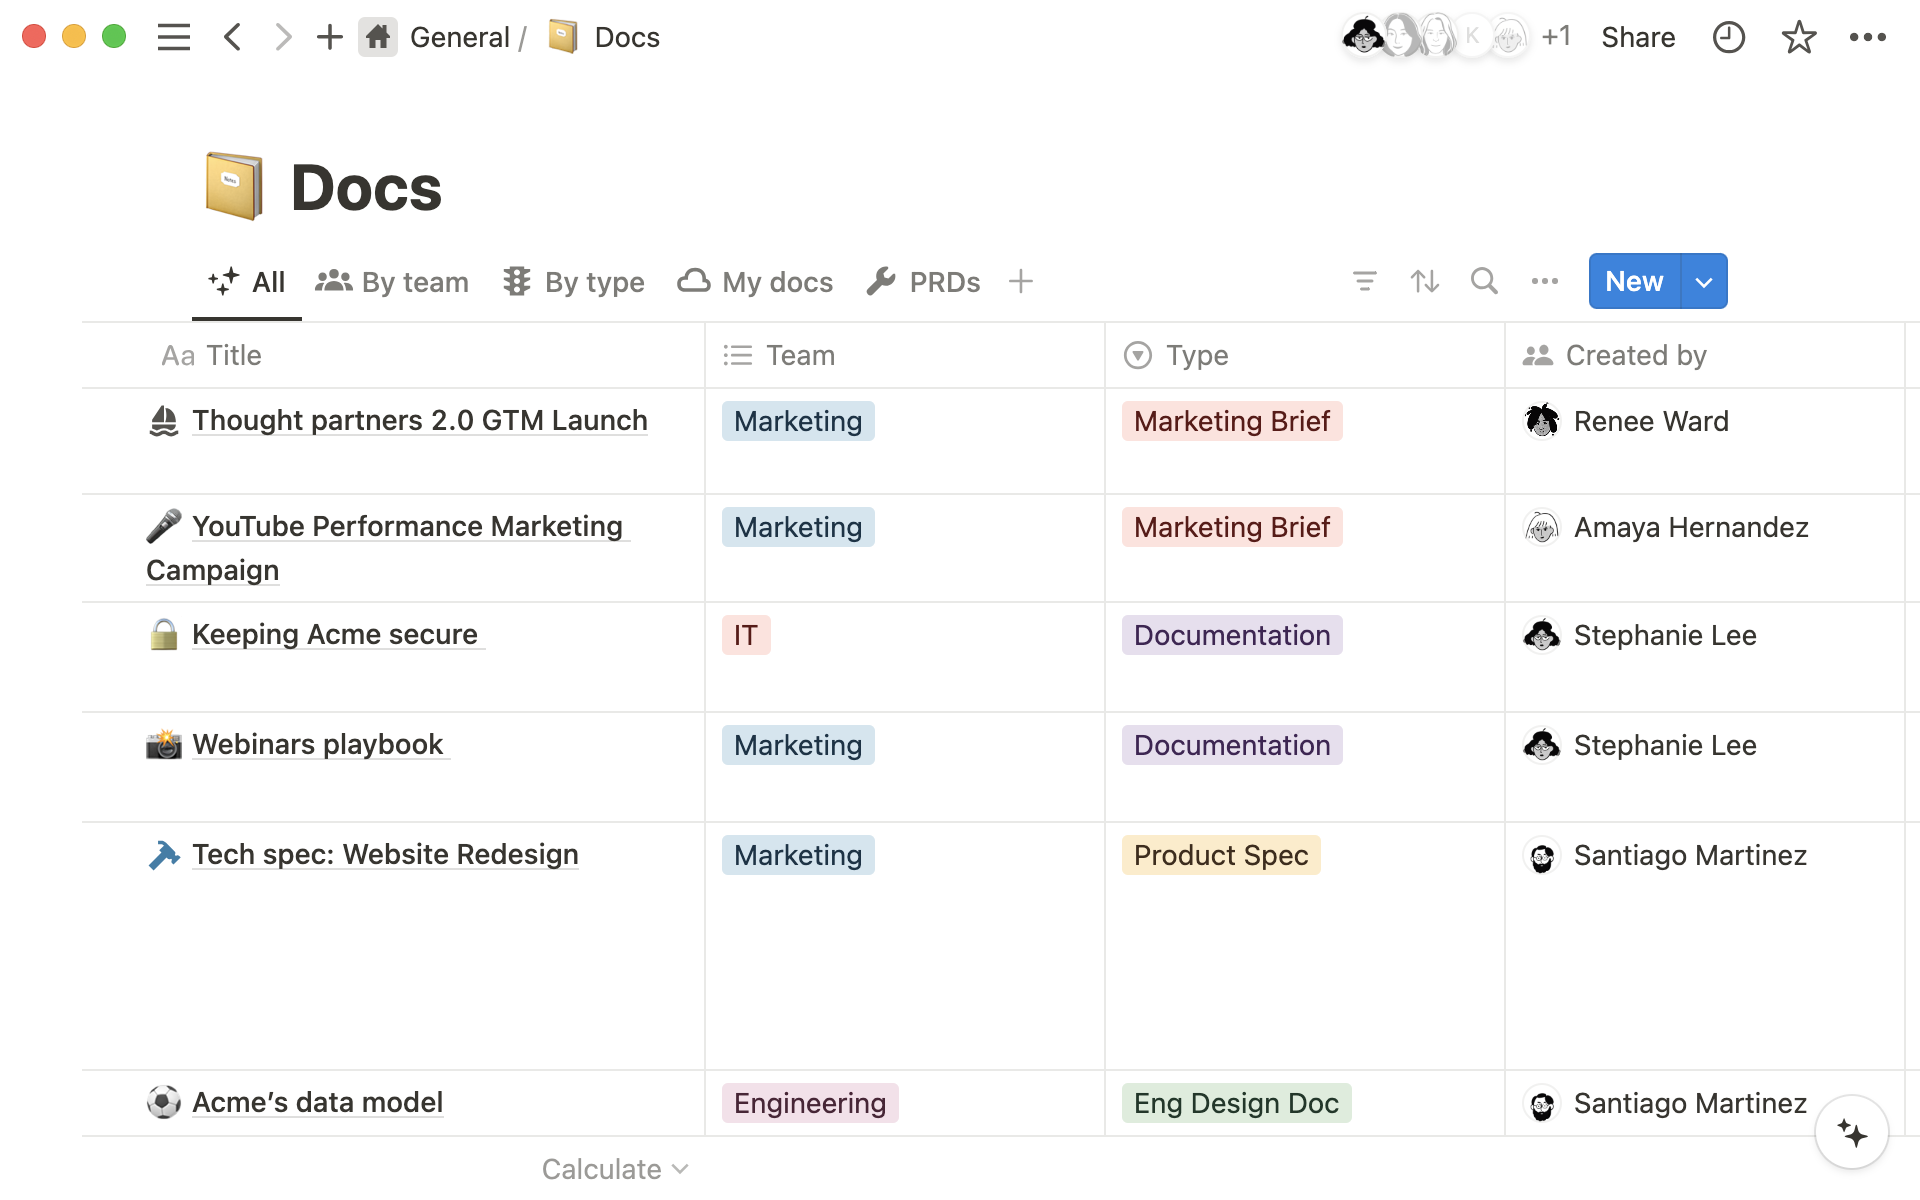



Here, a team manually adds rows everyday. No one deletes anything, but new rows get added everyday.

So, what method will you use to add this data everyday to a database destination? When you create a data pipeline, you have many ways to load this data into a destination.

## Methods of loading data to a database:

Here are some ways:

- You can Append
- You can Replace
- You can Merge

What can these look like? Here are some examples:

Appending Data            |  Replacing Data | Merging Data
:-------------------------:|:-------------------------:|:-------------------------:
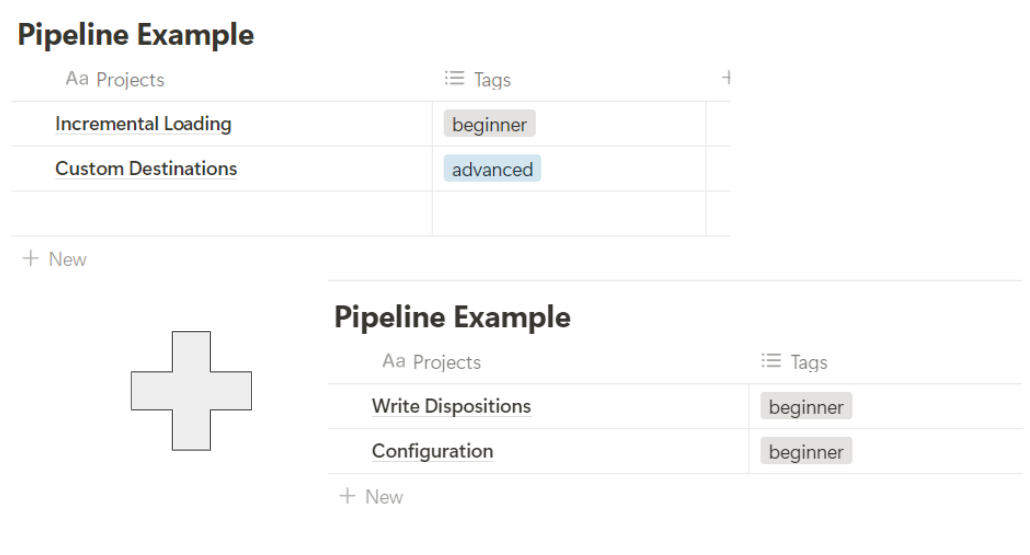 | 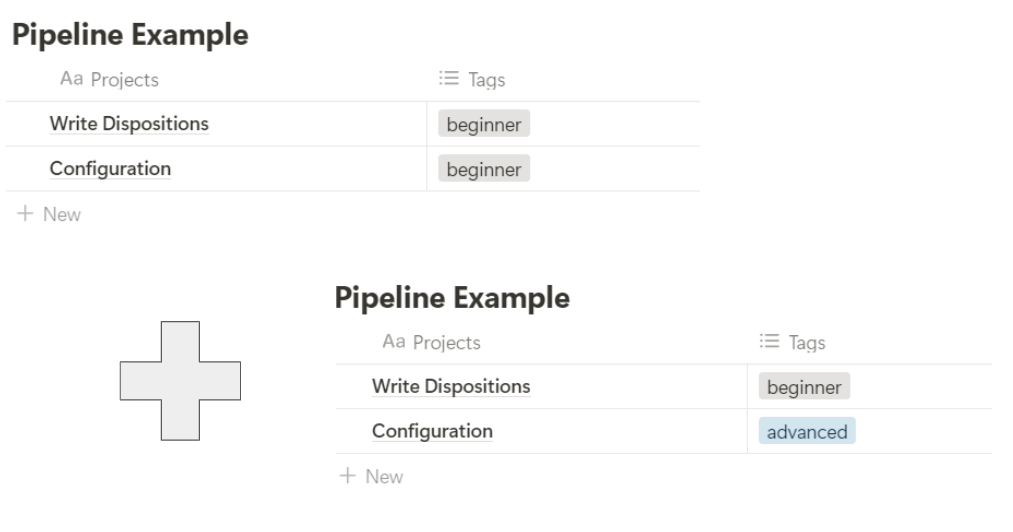 | 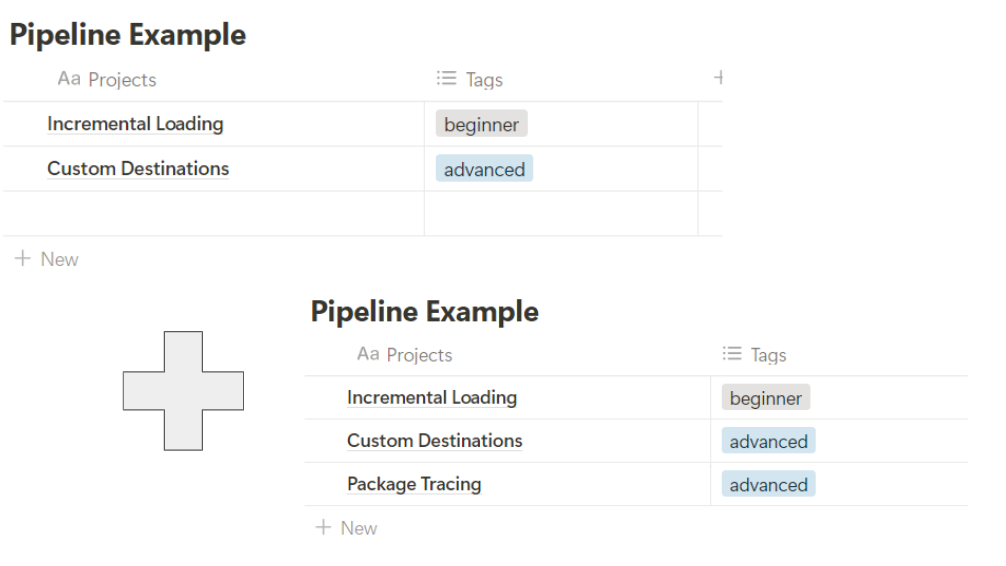

### If we go back to the use case from the first Notion page we imagined, which method of adding data to a database would work best? 👀

Answer: Replace, or Merge. Append would lead us to have duplicates.

# Write Dispositions in dlt



The methods we just saw in the previous example for loading data, are known as **write dispositions** in `dlt`.
These are set up with the resource decorator or pipeline runs.

dlt has 3 main methods of adding data:
1. Append
2. Replace
3. Merge

Moreover, there are 3 strategies to merge write disposition:
1. delete-insert strategy
2. scd2 strategy
3. upsert strategy

For this notebook, we'll be using the default delete-insert strategy.






## Example: The Hogwarts Admissions Department Data Pipeline

Let's look at a basic example, where you have been asked to set up a pipeline for the admissions department at Hogwarts School of Witchcraft and Wizardry:

In [2]:
import dlt
import pandas as pd
import duckdb

### Write Disposition 1: Append

In [3]:
# default case: append

@dlt.resource(name='creatures',
              primary_key='name',
              write_disposition='append')
def add_students(entries):
    for entry in entries:
        yield pd.DataFrame({
            "name": [entry[0]],
            "designation": ["student"],
            "date_started": [entry[1]]
        })


In [4]:
# declare the pipeline
pipeline = dlt.pipeline(pipeline_name='hogwarts_pipeline',
                        destination='duckdb',
                        dataset_name='hogwarts')

In [5]:
# first Harry joins:
pipeline.run(add_students([("Harry Potter", "1991-09-01T09:00:00Z")]))

# then, we append Ron and Hermione:
pipeline.run(add_students([("Ronald Weasley", "1991-09-01T09:00:00Z"),
                         ("Hermione Granger", "1991-09-01T09:00:00Z")]))

# then perhaps Ginny:
pipeline.run(add_students([("Ginny Weasley", "1991-09-01T09:00:00Z")]))

2024-09-02 04:29:29,488|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unmodified. It is up to destination to coerce the differences when loading. Change log level to INFO for more details.
2024-09-02 04:29:31,299|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unmodified. It is up to destination to coerce the differences when loading. Change log level to INFO for more details.
2024-09-02 04:29:31,309|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unm

LoadInfo(pipeline=<dlt.pipeline.pipeline.Pipeline object at 0x7a14704cf250>, metrics={'1725251372.8880424': [{'started_at': DateTime(2024, 9, 2, 4, 29, 33, 348260, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 9, 2, 4, 29, 34, 436418, tzinfo=Timezone('UTC')), 'job_metrics': {'creatures.418ac86835.parquet': LoadJobMetrics(job_id='creatures.418ac86835.parquet', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725251372.8880424/started_jobs/creatures.418ac86835.0.parquet', table_name='creatures', started_at=DateTime(2024, 9, 2, 4, 29, 33, 376939, tzinfo=Timezone('UTC')), finished_at=DateTime(2024, 9, 2, 4, 29, 33, 386541, tzinfo=Timezone('UTC')), state='completed', remote_url=None)}}]}, destination_type='dlt.destinations.duckdb', destination_displayable_credentials='duckdb:////content/hogwarts_pipeline.duckdb', destination_name='duckdb', environment=None, staging_type=None, staging_name=None, staging_displayable_credentials=None, destination_fingerprint='', datase

Let's look at the schema & data:

In [6]:
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')

conn.sql('SHOW ALL TABLES')

┌───────────────────┬──────────┬─────────────────────┬──────────────────────┬──────────────────────────────┬───────────┐
│     database      │  schema  │        name         │     column_names     │         column_types         │ temporary │
│      varchar      │ varchar  │       varchar       │      varchar[]       │          varchar[]           │  boolean  │
├───────────────────┼──────────┼─────────────────────┼──────────────────────┼──────────────────────────────┼───────────┤
│ hogwarts_pipeline │ hogwarts │ _dlt_loads          │ [load_id, schema_n…  │ [VARCHAR, VARCHAR, BIGINT,…  │ false     │
│ hogwarts_pipeline │ hogwarts │ _dlt_pipeline_state │ [version, engine_v…  │ [BIGINT, BIGINT, VARCHAR, …  │ false     │
│ hogwarts_pipeline │ hogwarts │ _dlt_version        │ [version, engine_v…  │ [BIGINT, BIGINT, TIMESTAMP…  │ false     │
│ hogwarts_pipeline │ hogwarts │ creatures           │ [name, designation…  │ [VARCHAR, VARCHAR, VARCHAR]  │ false     │
└───────────────────┴──────────┴

In [11]:
# another way of running this as above:
conn = duckdb.connect('hogwarts_pipeline.duckdb')
conn.sql('show all tables')

┌───────────────────┬──────────┬─────────────────────┬──────────────────────┬──────────────────────────────┬───────────┐
│     database      │  schema  │        name         │     column_names     │         column_types         │ temporary │
│      varchar      │ varchar  │       varchar       │      varchar[]       │          varchar[]           │  boolean  │
├───────────────────┼──────────┼─────────────────────┼──────────────────────┼──────────────────────────────┼───────────┤
│ hogwarts_pipeline │ hogwarts │ _dlt_loads          │ [load_id, schema_n…  │ [VARCHAR, VARCHAR, BIGINT,…  │ false     │
│ hogwarts_pipeline │ hogwarts │ _dlt_pipeline_state │ [version, engine_v…  │ [BIGINT, BIGINT, VARCHAR, …  │ false     │
│ hogwarts_pipeline │ hogwarts │ _dlt_version        │ [version, engine_v…  │ [BIGINT, BIGINT, TIMESTAMP…  │ false     │
│ hogwarts_pipeline │ hogwarts │ creatures           │ [name, designation…  │ [VARCHAR, VARCHAR, VARCHAR]  │ false     │
└───────────────────┴──────────┴

In [12]:
# note: since no table_name is set in the resource decorator, dlt takes the name arguement and dataset name to query the data.
conn.sql('select * from hogwarts.creatures')

┌──────────────────┬─────────────┬──────────────────────┐
│       name       │ designation │     date_started     │
│     varchar      │   varchar   │       varchar        │
├──────────────────┼─────────────┼──────────────────────┤
│ Harry Potter     │ student     │ 1991-09-01T09:00:00Z │
│ Ronald Weasley   │ student     │ 1991-09-01T09:00:00Z │
│ Hermione Granger │ student     │ 1991-09-01T09:00:00Z │
│ Ginny Weasley    │ student     │ 1991-09-01T09:00:00Z │
└──────────────────┴─────────────┴──────────────────────┘

### Write Disposition 2: Merge

Oops! Ginny starts a year later than Harry, Ron and Hermione. So we must update her date of joining.

This requires us to **merge** the original dataset row with the new one. Here's how we can do that:

In [13]:
pipeline.run(
    add_students([("Ginny Weasley", "1992-09-01T09:00:00Z")]),
    primary_key="name",
    write_disposition="merge"
)

2024-09-02 04:40:47,432|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unmodified. It is up to destination to coerce the differences when loading. Change log level to INFO for more details.


LoadInfo(pipeline=<dlt.pipeline.pipeline.Pipeline object at 0x7a14704cf250>, metrics={'1725252047.4262857': [{'started_at': DateTime(2024, 9, 2, 4, 40, 47, 875031, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 9, 2, 4, 40, 50, 6742, tzinfo=Timezone('UTC')), 'job_metrics': {'creatures.df9552b19e.parquet': LoadJobMetrics(job_id='creatures.df9552b19e.parquet', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725252047.4262857/started_jobs/creatures.df9552b19e.0.parquet', table_name='creatures', started_at=DateTime(2024, 9, 2, 4, 40, 47, 984787, tzinfo=Timezone('UTC')), finished_at=DateTime(2024, 9, 2, 4, 40, 47, 991842, tzinfo=Timezone('UTC')), state='completed', remote_url=None), 'creatures.0a0a092145.sql': LoadJobMetrics(job_id='creatures.0a0a092145.sql', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725252047.4262857/started_jobs/creatures.0a0a092145.0.sql', table_name='creatures', started_at=DateTime(2024, 9, 2, 4, 40, 48, 988234, tzinfo=Tim

We see Ginny's `date_started` get updated:

In [14]:
conn.sql('select * from hogwarts.creatures')

┌──────────────────┬─────────────┬──────────────────────┐
│       name       │ designation │     date_started     │
│     varchar      │   varchar   │       varchar        │
├──────────────────┼─────────────┼──────────────────────┤
│ Harry Potter     │ student     │ 1991-09-01T09:00:00Z │
│ Ronald Weasley   │ student     │ 1991-09-01T09:00:00Z │
│ Hermione Granger │ student     │ 1991-09-01T09:00:00Z │
│ Ginny Weasley    │ student     │ 1992-09-01T09:00:00Z │
└──────────────────┴─────────────┴──────────────────────┘

#### Staging

Let's see if the merge operation changed anything in the schema

In [15]:
conn.sql('SHOW ALL TABLES')

┌───────────────────┬──────────────────┬─────────────────────┬──────────────────────┬──────────────────────┬───────────┐
│     database      │      schema      │        name         │     column_names     │     column_types     │ temporary │
│      varchar      │     varchar      │       varchar       │      varchar[]       │      varchar[]       │  boolean  │
├───────────────────┼──────────────────┼─────────────────────┼──────────────────────┼──────────────────────┼───────────┤
│ hogwarts_pipeline │ hogwarts         │ _dlt_loads          │ [load_id, schema_n…  │ [VARCHAR, VARCHAR,…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ _dlt_pipeline_state │ [version, engine_v…  │ [BIGINT, BIGINT, V…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ _dlt_version        │ [version, engine_v…  │ [BIGINT, BIGINT, T…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ creatures           │ [name, designation…  │ [VARCHAR, VARCHAR,…  │ false     │
│ hogwarts_pipeline │ hogwarts_s

We see the introduction of a new schema called `hogwarts_staging`. Let's check the content:

In [16]:
conn.sql('select * from hogwarts_staging.creatures')

┌───────────────┬─────────────┬──────────────────────┐
│     name      │ designation │     date_started     │
│    varchar    │   varchar   │       varchar        │
├───────────────┼─────────────┼──────────────────────┤
│ Ginny Weasley │ student     │ 1992-09-01T09:00:00Z │
└───────────────┴─────────────┴──────────────────────┘

We see that only the row we changed got added into this staging table 🤔

In this default merge strategy (delete-insert), `dlt` loads data to a **staging dataset**, deduplicates the staging data if a `primary_key` is provided, deletes the data from the destination using `merge_key` and `primary_key`, and then inserts the new records.

All of this happens in a single atomic transaction for a parent and all child tables. 🎉

In [17]:
conn.sql('select * from hogwarts_staging.creatures').df()     # same as above in a table format

,name,designation,date_started
0,Ginny Weasley,student,1992-09-01T09:00:00Z


### Write Disposition 3: Replace

A Gryffindor House hater steps in as the new data engineer and wants the destination database to **only contain students from another House**. He has a record of only 🐍 Slytherin students and wants to add them instead:

In [18]:
pipeline.run(
    add_students([("Draco Malfoy", "1991-09-01T09:00:00Z"),
                  ("Vincent Crabbe", "1991-09-01T09:00:00Z"),
                  ("Gregory Goyle", "1991-09-01T09:00:00Z")]),
    write_disposition="replace"
)

2024-09-02 04:48:38,686|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unmodified. It is up to destination to coerce the differences when loading. Change log level to INFO for more details.
2024-09-02 04:48:38,692|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unmodified. It is up to destination to coerce the differences when loading. Change log level to INFO for more details.
2024-09-02 04:48:38,698|[WARNING]|214|134229528121344|dlt|extractors.py|_compute_table:441|In resource: creatures, when merging arrow schema with dlt schema, several column hints were different. dlt schema hints were kept and arrow schema and data were unm

LoadInfo(pipeline=<dlt.pipeline.pipeline.Pipeline object at 0x7a14704cf250>, metrics={'1725252518.6803107': [{'started_at': DateTime(2024, 9, 2, 4, 48, 39, 177691, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 9, 2, 4, 48, 40, 257046, tzinfo=Timezone('UTC')), 'job_metrics': {'creatures.bd7402d598.parquet': LoadJobMetrics(job_id='creatures.bd7402d598.parquet', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725252518.6803107/started_jobs/creatures.bd7402d598.0.parquet', table_name='creatures', started_at=DateTime(2024, 9, 2, 4, 48, 39, 237273, tzinfo=Timezone('UTC')), finished_at=DateTime(2024, 9, 2, 4, 48, 39, 245823, tzinfo=Timezone('UTC')), state='completed', remote_url=None), '_dlt_pipeline_state.6cdec7e4ee.insert_values': LoadJobMetrics(job_id='_dlt_pipeline_state.6cdec7e4ee.insert_values', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725252518.6803107/started_jobs/_dlt_pipeline_state.6cdec7e4ee.0.insert_values', table_name='_dlt_pipeli

Let's take a look at the database now. Poof* all Gryffindor kids got erased.

In [ ]:
conn.sql('select * from hogwarts.creatures')

┌────────────────┬─────────────┬──────────────────────┐
│      name      │ designation │     date_started     │
│    varchar     │   varchar   │       varchar        │
├────────────────┼─────────────┼──────────────────────┤
│ Draco Malfoy   │ student     │ 1991-09-01T09:00:00Z │
│ Vincent Crabbe │ student     │ 1991-09-01T09:00:00Z │
│ Gregory Goyle  │ student     │ 1991-09-01T09:00:00Z │
└────────────────┴─────────────┴──────────────────────┘

In [19]:
# another way to check table.
conn.sql('select * from hogwarts.creatures').df()

,name,designation,date_started
0,Draco Malfoy,student,1991-09-01T09:00:00Z
1,Vincent Crabbe,student,1991-09-01T09:00:00Z
2,Gregory Goyle,student,1991-09-01T09:00:00Z


# Real Life Use Case

Now, let's explore how we can ensure that no duplicates exist within our data table using dlt's deduplication methods.

**Step 1. Create a pipeline**

The following code creates and runs a pipeline from the GitHub API endpoint to the duckdb destination:

In [20]:
import dlt
import duckdb
from dlt.sources.helpers import requests

# Specify the URL of the API endpoint
url = "https://api.github.com/repos/dlt-hub/dlt/issues"
# Make a request and check if it was successful
response = requests.get(url)
response.raise_for_status()

pipeline = dlt.pipeline(
    pipeline_name="github_issues",
    destination="duckdb",
    dataset_name="github_data",
)
# The response contains a list of issues
load_info = pipeline.run(response.json(), table_name="issues")

print(load_info)

Pipeline github_issues load step completed in 1.41 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_issues.duckdb location to store data
Load package 1725252697.5708337 is LOADED and contains no failed jobs


**Step 2. Inspect the created dataset**

In [21]:
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
conn.sql('select * from github_data.issues')

┌──────────────────────┬──────────────────────┬───┬──────────────────────┬────────────────┬──────────────────────┐
│         url          │    repository_url    │ … │ assignee__received…  │ assignee__type │ assignee__site_admin │
│       varchar        │       varchar        │   │       varchar        │    varchar     │       boolean        │
├──────────────────────┼──────────────────────┼───┼──────────────────────┼────────────────┼──────────────────────┤
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL           │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User           │ false                │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User           │ false                │
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL           │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ https://api.github…  │ User 

In [22]:
# Inspect schema
conn.sql('show all tables')

┌───────────────┬─────────────┬─────────────────────┬──────────────────────┬───────────────────────────────┬───────────┐
│   database    │   schema    │        name         │     column_names     │         column_types          │ temporary │
│    varchar    │   varchar   │       varchar       │      varchar[]       │           varchar[]           │  boolean  │
├───────────────┼─────────────┼─────────────────────┼──────────────────────┼───────────────────────────────┼───────────┤
│ github_issues │ github_data │ _dlt_loads          │ [load_id, schema_n…  │ [VARCHAR, VARCHAR, BIGINT, …  │ false     │
│ github_issues │ github_data │ _dlt_pipeline_state │ [version, engine_v…  │ [BIGINT, BIGINT, VARCHAR, V…  │ false     │
│ github_issues │ github_data │ _dlt_version        │ [version, engine_v…  │ [BIGINT, BIGINT, TIMESTAMP …  │ false     │
│ github_issues │ github_data │ issues              │ [url, repository_u…  │ [VARCHAR, VARCHAR, VARCHAR,…  │ false     │
│ github_issues │ github_data │ 

**Step 3. Duplication**

Run steps 1 and 2 again.

Do you notice anything new? You should see the number of rows double, meaning there are two of each data point, since we did not run the pipeline with instructions to replace or merge incoming data.

**Why does this happen?** Duplicates appear in our data set, beacause the default load mode is `append`. To get the latest data without duplicates, run the script below, which sets the write disposition to `replace`.


In [23]:
import dlt
from dlt.sources.helpers import requests

# Specify the URL of the API endpoint
url = "https://api.github.com/repos/dlt-hub/dlt/issues"
# Make a request and check if it was successful
response = requests.get(url)
response.raise_for_status()

pipeline = dlt.pipeline(
    pipeline_name='github_issues',
    destination='duckdb',
    dataset_name='github_data',
)
# The response contains a list of issues
load_info = pipeline.run(
    response.json(),
    table_name="issues",
    write_disposition="replace"  # <-- Add this line
)

print(load_info)

Pipeline github_issues load step completed in 1.12 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_issues.duckdb location to store data
Load package 1725252940.7572918 is LOADED and contains no failed jobs


**Step 4. Incremental Loading**

To load new data as it arrives, we can adjust the code above so that it now supports incremental loading. To do so we should:

1. Use the @dlt.resource Decorator:

    a. Declares the table name.
  
    b. Specifies the append write disposition.

2. `get_issues` Function:

    a. Fetches and yields data page by page.
   
    b. Tracks the created_at field to filter only new data. This field is tracked using `dlt.sources.incremental`.

What is this `dlt.sources.incremental`?

- It is used to track a specific field in the data that indicates new or updated records.
- It is often a timestamp or a sequence number (like the `created_at` field).
- It keeps track of the last value of this field from the previous run and uses it to filter in the newly created or updated records in the current run.

In [24]:
@dlt.resource(table_name="issues", write_disposition="replace")
def get_issues(
    created_at=dlt.sources.incremental("created_at", initial_value="1970-01-01T00:00:00Z")
):
    # NOTE: we read only open issues to minimize number of calls to the API.
    # There's a limit of ~50 calls for not authenticated Github users.
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/issues"
        "?per_page=100&sort=created&directions=desc&state=open"
    )

    while True:
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()

        # Stop requesting pages if the last element was already older than initial value
        # Note: incremental will skip those items anyway, we just do not want to use the api limits
        if created_at.start_out_of_range:
            break

        # get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]

pipeline = dlt.pipeline(
    pipeline_name="github_issues_incremental",
    destination="duckdb",
    dataset_name="github_data_append",
)

load_info = pipeline.run(get_issues)

print(load_info)

Pipeline github_issues_incremental load step completed in 1.34 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_append
The duckdb destination used duckdb:////content/github_issues_incremental.duckdb location to store data
Load package 1725253152.3913407 is LOADED and contains no failed jobs


**Step 5. Update and de-duplicate data**

To keep the database updated with the latest content, including updates to existing records, you can combine incremental loading with the merge write disposition.

Changes:

* `@dlt.resource Decorator`:

    a. Use write_disposition='merge' to update existing records.

    b. Add `primary_key` to identify duplicates for merging.

A **primary key** uniquely identifies records in the database, enabling dlt to detect and merge duplicates effectively

In [25]:
@dlt.resource(
    table_name="issues",
    write_disposition="merge",
    primary_key="id",
)
def get_issues(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    # NOTE: we read only open issues to minimize number of calls to
    # the API. There's a limit of ~50 calls for not authenticated
    # Github users
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/issues"
        f"?since={updated_at.last_value}&per_page=100&sort=updated"
        "&directions=desc&state=open"
    )

    while True:
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]

pipeline = dlt.pipeline(
    pipeline_name="github_issues_merge",
    destination="duckdb",
    dataset_name="github_data_merge",
)
load_info = pipeline.run(get_issues)

print(load_info)

Pipeline github_issues_merge load step completed in 2.43 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data_merge
The duckdb destination used duckdb:////content/github_issues_merge.duckdb location to store data
Load package 1725253269.205642 is LOADED and contains no failed jobs


Visualize these changes by running the following code:

In [26]:
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')
conn.sql('select * from github_data_merge.issues')

┌──────────────────────┬──────────────────────┬───┬──────────────────────┬──────────────────────┬──────────────────────┐
│         url          │    repository_url    │ … │ performed_via_gith…  │ performed_via_gith…  │ performed_via_gith…  │
│       varchar        │       varchar        │   │       varchar        │       varchar        │       varchar        │
├──────────────────────┼──────────────────────┼───┼──────────────────────┼──────────────────────┼──────────────────────┤
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL                 │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL                 │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL                 │ NULL                 │
│ https://api.github…  │ https://api.github…  │ … │ NULL                 │ NULL                 │ NULL                 │
│ https://api.github…  │ https:/

**How does this work?**

* Merge Write Disposition: `@dlt.resource(write_disposition='merge' primary_key='id')` updates existing records based on the primary key.


* Track `updated_at` Field: Filters issues updated since the last run.


* Use since Parameter: Passes `updated_at.last_value` to the API to fetch only updated issues.

**Running the Script**

* Initial Run: Loads all issues into the database.

* Subsequent Runs: Loads only new and updated issues, merging changes with existing records.

This approach ensures the database always contains the most up-to-date information.